In [1]:
import pandas as pd 
import numpy as np
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

from pylab import *


nltk.download('stopwords')
nltk.download('tagsets')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/javier/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package tagsets to /Users/javier/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

In [19]:
tc_data = pd.read_csv('../data/TalentConnect.csv', index_col=0)
db_data = pd.read_csv('../data/JobsDB.csv', index_col=0)
index = range(1,len(db_data)+1)
db_data.insert(loc=0, column="source",value = ["JobsDB" for i in index])
db_data.insert(loc=0, column="index",value = index)
db_data = db_data.rename(columns={"Job description": "Job Description"})

tc_index = range(1,len(tc_data)+1)
tc_data.insert(loc=0, column="source",value = ["TalentConnect" for i in tc_index])
tc_data.insert(loc=0, column="index",value = tc_index)
tc_data = tc_data.rename(columns={"Job Title": "job-title", "Internship/Project Description": "Job Description",
                                 "Employer": "company"})

tc_data = tc_data[['index','source','job-title','Job Description','cleaned_text','company']]
db_data = db_data[['index','source','job-title','Job Description','cleaned_text','company']]
frame =[tc_data,db_data]
job_df = pd.concat(frame)

Combined the TalentConnect data and JobsDB data for clustering. Index and source are added to locate the jobs in seperate dataframe later.

In [20]:
stop = ['policy','result','science','proficiency','hour','office','following','matter','thing','used','requirement','skill','way','http','www','com','fixed','income','apply','parent','self','set','outcome','area','testing','course','growing','day','scene','sport','go','company','ability','player','base','end','unit','opportunity','sgd','scientist','providing','image','cc','failure','create','hand','tool','query','spring','store','offer','documentation','technique','battery','problem','solution','eat','drink','maintain','location','concept','output','candidate','generate']
vectorizer = TfidfVectorizer(stop_words=stop,analyzer='word',ngram_range=(1,2))
tfidf = vectorizer.fit_transform(job_df['cleaned_text'])
feature_names = vectorizer.get_feature_names()

/Users/javier/miniforge3/envs/nlp/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [21]:
def plot_kmeans(tfidf, min_K=2, max_K=30):
    sum_of_squared_distances = []

    for k in range(min_K, max_K):
        km = KMeans(n_clusters=k, max_iter=200, n_init=10)
        km = km.fit(tfidf)
        sum_of_squared_distances.append(km.inertia_)

    plt.plot(range(min_K, max_K), sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

In [22]:
def get_clusters(k):
    model = KMeans(n_clusters=k, init='k-means++', max_iter=200, n_init=10)
    model.fit(tfidf)

    labels = model.labels_
    clusters = pd.DataFrame(list(zip(job_df["job-title"], labels)), columns=['title','cluster'])
    print(clusters.sort_values(by=['cluster']))
    
    result = {'cluster':labels, "job title":job_df["job-title"], 'description':job_df['Job Description'],'source':job_df['source'],'index':job_df['index']}
    return pd.DataFrame(result), model   

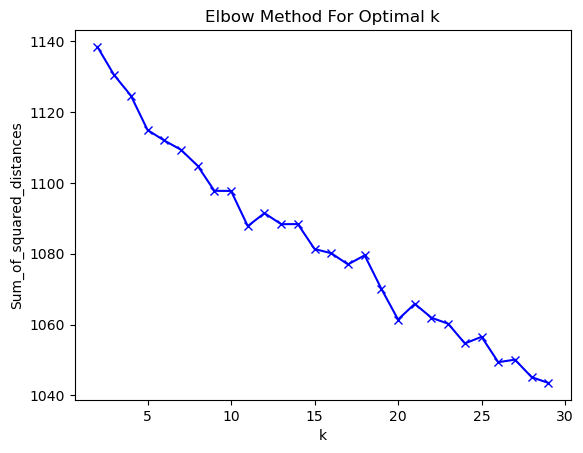

In [23]:
plot_kmeans(tfidf)

In [24]:
num_clusters = 8
clustered_data, km = get_clusters(num_clusters)
pred = km.predict(tfidf)
clustered_data

                                                  title  cluster
1032                          Machine Learning Engineer        0
343                                    Insights Analyst        0
598                                  Lead Data Engineer        1
708                                       Data Engineer        1
709                                IT Data Ops Engineer        1
...                                                 ...      ...
308   Business Analyst, Southeast Asia, Japan & Sout...        7
306                     data manager, data science & bi        7
305        Data Strategy Manager - Applied Intelligence        7
304   Anaylst, Strategy Management and Analytics (Or...        7
0                College Intern - Data Science (Remote)        7

[1197 rows x 2 columns]


,cluster,job title,description,source,index
0,7,College Intern - Data Science (Remote),Team Description: This position is with the Da...,TalentConnect,1
1,7,Junior Data Scientist,This role is a great opportunity to be involve...,TalentConnect,2
2,7,Data Science_AMTNP,Modern manufacturing is no longer just about f...,TalentConnect,3
3,7,Digital Performance Management_NPAMT,"In alignment with the digitalisation, data and...",TalentConnect,4
4,7,Digital Twin_NPAMT,Opportunity Statement Dolutegravir (or “DTG”)...,TalentConnect,5
...,...,...,...,...,...
1041,3,Senior/ Research Engineer,Project OverviewCell therapy is an emerging cl...,JobsDB,1042
1042,7,GAMMA Software Engineer,Who We Are Boston Consulting Group partners wi...,JobsDB,1043
1043,5,Software Engineer - Ads Infrastructure #JobsTh...,Responsibilities TikTok is the leading destina...,JobsDB,1044
1044,3,Research Fellow (Machine Learning and Human Ma...,Centre for Advanced Robotics Technology Innova...,JobsDB,1045


In [25]:
centers = km.cluster_centers_

ordered_centers = centers.argsort()[:,::-1]
cluster_keywords = {}
for i in range(8):
    cluster_keywords[i] = []
    for x in ordered_centers[i][:5]:
        cluster_keywords[i].append(feature_names[x])
    cluster_keywords[i] = ', '.join(cluster_keywords[i])
cluster_keywords

{0: 'partner client, client, tookitaki, partner, manager partner',
 1: 'data, experience, business, pipeline, analytics',
 2: 'hpb, health, data, part, programme',
 3: 'learning, machine, machine learning, research, data',
 4: 'risk, data, business, conduct, analytics',
 5: 'tiktok, data, inspire creativity, inspire, creativity',
 6: 'vehicle, student, research, learning, campus',
 7: 'data, business, analytics, experience, team'}

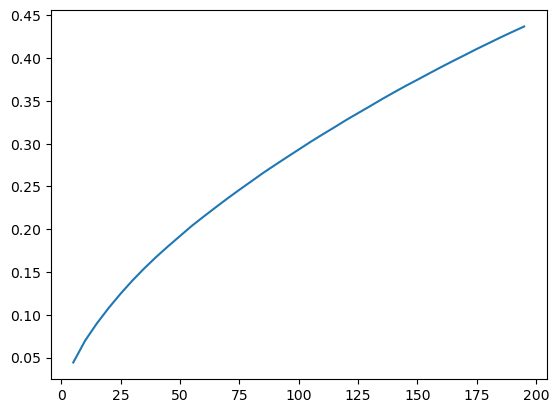

In [26]:
vars = []
n_range = list(range(5,200,5))
for n in n_range:
    svd = TruncatedSVD(n)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd,normalizer)

    x = lsa.fit_transform(tfidf)
    var_explained = svd.explained_variance_ratio_.sum()
    vars.append(var_explained)
    
plt.plot(n_range,vars)
plt.show()

In [27]:
svd = TruncatedSVD(100)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd,normalizer)
tfidf = lsa.fit_transform(tfidf)

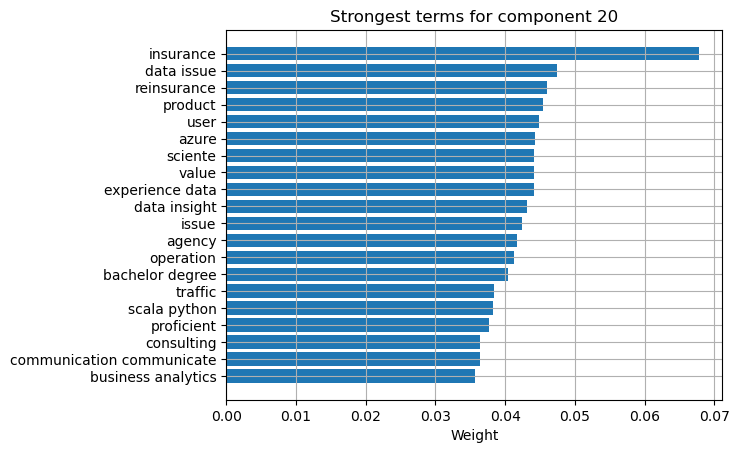

In [28]:
# Important components
comp = svd.components_[99]
indices = np.argsort(comp).tolist()
indices.reverse()
terms = [feature_names[i] for i in indices[0:20]]
weights = [comp[i] for i in indices[0:20]]
terms.reverse()
weights.reverse()

positions = arange(20) + .5    # the bar centers on the y axis

figure(10)
barh(positions, weights, align='center')
yticks(positions, terms)
xlabel('Weight')
title('Strongest terms for component %d' % (20))
grid(True)
show()

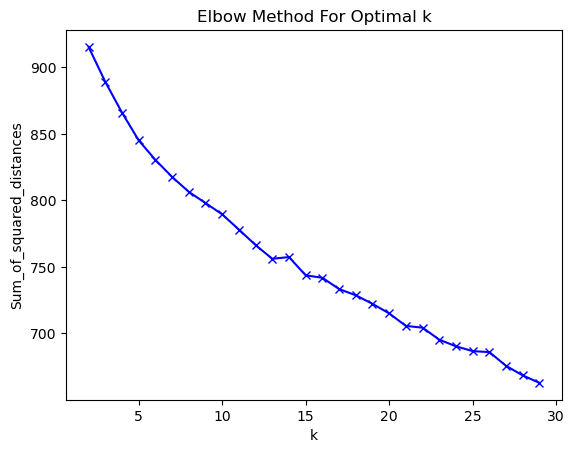

In [29]:
plot_kmeans(tfidf)

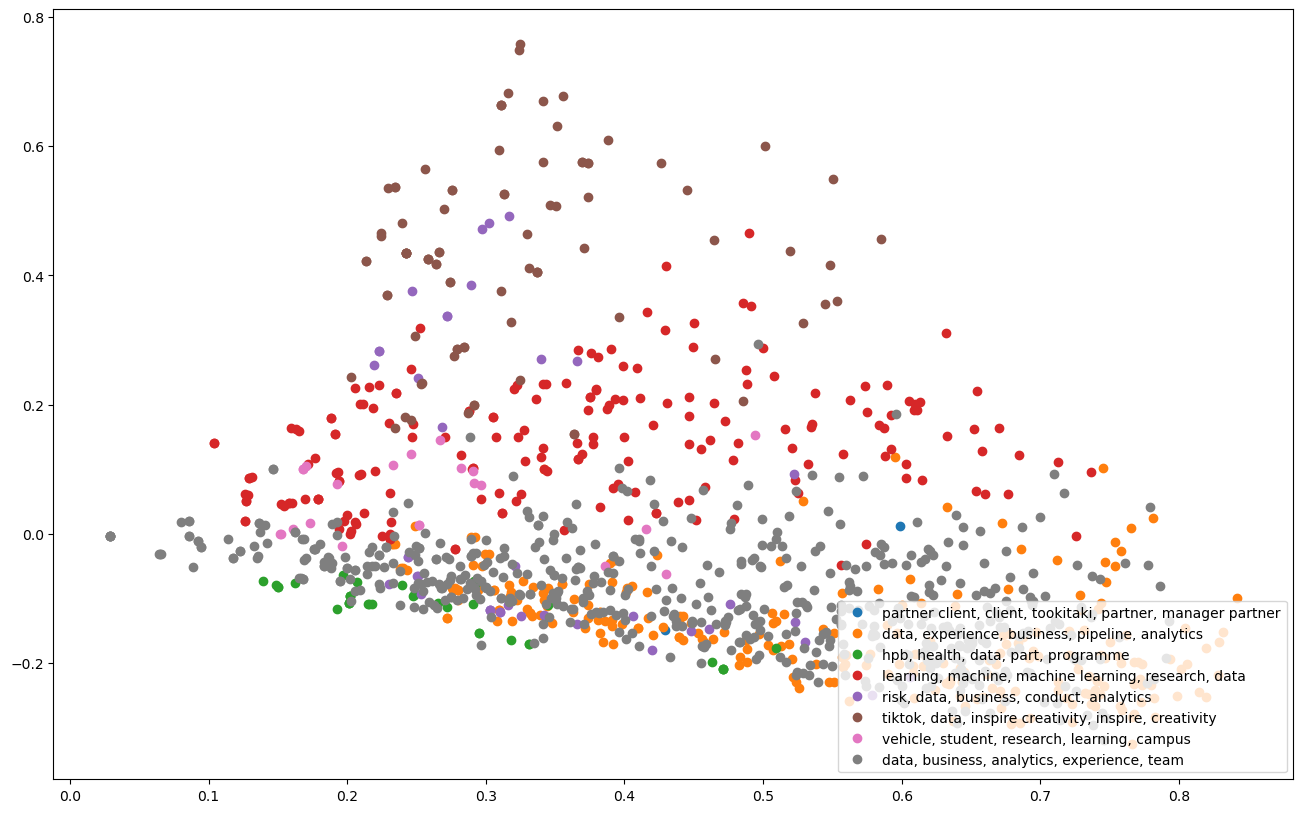

In [30]:
x = tfidf[:,0]
y = tfidf[:,1]
clusters = clustered_data['cluster']
df = pd.DataFrame(dict(x=x,y=y,label=clusters))
groups = df.groupby(clusters)
fig, ax = plt.subplots(figsize=(16,10))
for cluster_name, cluster in groups:
    ax.plot(cluster.x, cluster.y, marker='o', linestyle='', label = cluster_keywords[cluster_name])
ax.legend(numpoints=1,loc=4)
plt.show()

Cluster: 0
Titles:
Insights Analyst
Machine Learning Engineer


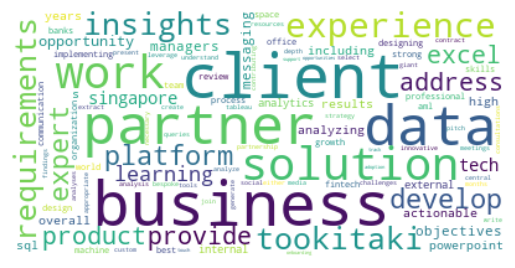

Cluster: 1
Titles:
Data Engineering Intern
Sr. Business Intelligence Engineer, WW Sales-Tech, Business Intelligence & Analytics
Digital Business Analyst - (Data Analytics) #JobsThatMatter
Digital Business Analyst (Data Analytics) #JobsThatMatter
DATA ANALYTICS LEAD
Senior Manager Business Analytics and Integration
Data Analytics Manager
Senior Lead, Data & Analytics
Senior Manager, IS&T, Business Analytics & Integration (Based in Singapore)
Sr. Business Insights Analyst
Business Analyst (6 - 12 months contract) Convertible
System Analyst (Business Intelligence)
Data Visualization & Analytics Lead - Associate #JPM #Immediate #WorkNow #JobsThatMatter
Practice Lead/Senior Leader, Data Analytics & AI
Visualisation Analyst
Data Analyst Compliance
Manager, Data Analytics
Data Analyst
Data analyst
Deputy/Assistant Director, Data Analytics and Engineering Division
Vice President, Data Scientist, Big Data Analytics Centre, Data Management Office
Senior Data Analyst (Power BI)
Data analyst bank 

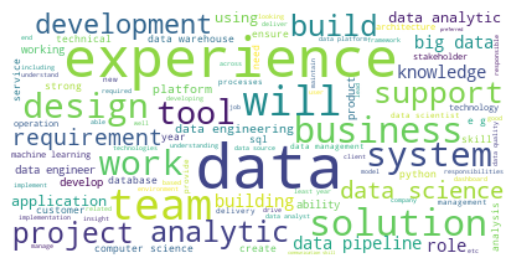

Cluster: 2
Titles:
Health Insights Singapore Project- Jul to Dec 2021
National Population Health Survey (NPHS) Jul-Dec 21
Data Analytics & Science in Physical Activity Domain Jul-Dec
Big data engineering on HPB population-based platform-Dec21
Data Analytics & Science in Physical Activity Dec-May22
DaHealth Insights Singapore Project- Dec-May22 (Admin)
Health Insights Singapore Project- Dec21-May 22 Stats
National Population Health Survey (NPHS) Dec-May 22
Outreach/Planning for Education Institution Sector Dec-May22
HPB’s population-based data science platform DA Dec-May22
Outreach/Planning for Education Institution Sector DA Dec21
National Population Health Survey (NPHS) DA Dec-May 22
HPB’s population-based data science platform DA Dec21-May22
HealthLine Support for HPB Programme DA Dec21-May22
Health Insights Singapore Project (Data Analytics)Dec-May 22
Eat Drink Shop Healthy/Healthier Ingredient Devt DA Dec21
Data Analytics & Science in Physical Activity DA Dec-May22
Health Insights 

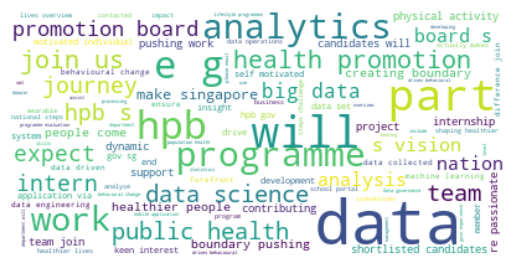

Cluster: 3
Titles:
Data Science Intern
Data Sciece for Industrial 4.0 Machine IOT
Software Engineer Data Science
Software engineer data science DSA4299 sem2
Internship - Machine Learning For Yield Analysis (ID:323386)
Internship - Data Science Analyst (ID: 323445)
Data Scientist intern
Data Scientist Intern
Contract Data Scientist - Business Intelligence and Analytics
Research Fellow (Quantum Information and Data Analytics)
Data Analytics
Research Associate / (Data Analyst & Machine Learning Specialist) R00008084
Data Scientist (Global)
Senior Data Engineer
Data Engineer (Senior Manager)
Project Officer (Programmer/Data Engineer)
Senior Data Sciences & Analytics Engineer (Data Science Track)
Data Science Engineer
Software engineer data science / python
Data Engineer
Senior Data Sciences & Analytics Engineer (Machine Learning Track)
Research Engineer II, (Data Science and AI) - R00011099
Data Scientist
AVP, Data Scientist, HR Analytics
Data Scientist - AI Lab, Group Data Office
Data Sci

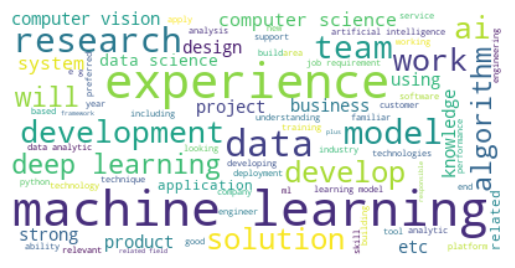

Cluster: 4
Titles:
Assistant Vice President/Vice President, Analytics Specialist, Group Retail  Business Risk and Control Management, COO Office
Director / Business Process - Analytics.
Head, - Business Process and Analytics.*
Manager / Audit Analytics
Associate Director, Analytics & Visualization, - (2200017090)*
.IMO Enablement Productivity Specialist.'
Director, Business Analytics & Insights
IMO / Enablement Productivity Specialist. *
Lead Knowledge Manager, CABM Data and Analytics, - (2200019112). *
IBOR Programme / Data Analytics Reg Reporting.*
IMO Enablement Productivity Specialist - Data and Analytics
Lead
Associate, ESG Data Solutions & Analytics, - (2200012092)*
Associate Director, ESG Data Solutions & Analytics, - (2200012091) *
Manager, - Analytics & Visualization.
Product Owner, - Commercial Analytics Platform ESG - (2200006019).*
IMO Enablement Productivity Specialist
Data Profiling & Analytics Lead, - (2200011163)
Data Profiling & Analytics Lead - (2200011163).'* #JobsT

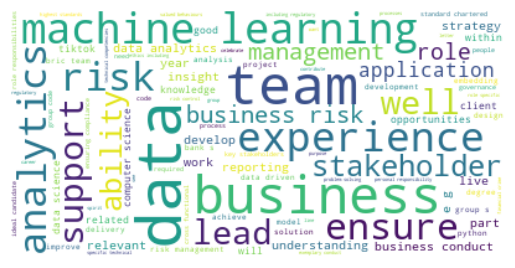

Cluster: 5
Titles:
HR Analytics - Trust & Safety - SG #Urgent #WorkNow
Programs Partner, - Talent Analytics - Trust & Safety - Singapore*
Product Data Analyst - Data Analysis #JobsThatMatter*
Data Science Analyst, TikTok #Urgent*
Data Analyst - Growth #Immediate
Product data analyst
Data Analyst Intern - Growth #URGENT*
Data Scientist Intern, Growth - #JobsThatMatter*
Ads Policy Analyst (Data)
Data Engineer - Global Payments #Urgent
Data Engr. - Growth - #JobsThatMatter*
Sr. Analyst, Data Loss Prevention (DLP) Operations
Data Engineer Intern, TikTok #WorkNow #JobsThatMatter*
Big Data Engineer - Recommendation Architecture*
Data engineer data
Data Engineer, TikTok* #Immediate
Data Intelligence Engineer, - Global Payments #Urgent
Software Engineer (Backend Systems), Data Platform #JobsThatMatter
Software Engineer - (Log / Big Data Processing / ELK), Cloud Infrastructure*
Software Engineer, (Enterprise) Data Platform #JobsThatMatter*
Backend Software Engineer, - TikTok e-Commerce Data Pla

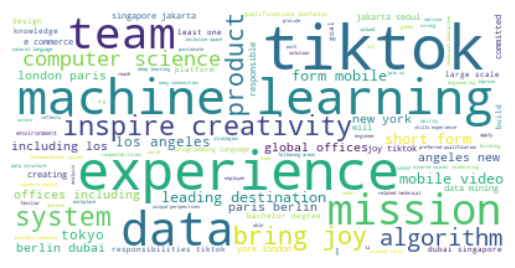

Cluster: 6
Titles:
Senior Professional Officer, Business Analytics
Teaching Assistant, Business Analytics and Information Systems
Senior Professional Officers, Business Analytics
Assistant Principal Data Analyst
Assistant Principal Data Scientist
Research Associate (Clinical Data Engineer)
Data Engineer for AI Singapore
Principal/Assistant Principal/Senior Data Scientist
Research Associate / Research Fellow, Data Scientist
Data Analyst / Data Scientist (Learning Analytics)
Research Engineer, Machine Learning and Operations Research
Research Engineer, Machine/Deep Learning and Network Security
Research Engineer (Communication Learning for Autonomous Vehicles)
Research Assistant, Communication Learning for Autonomous Vehicles
Snr AI Engineer / AI Engineer for AI Singapore (Innovation)
Research Engineer NLP Research for ML and AI Automation
CV Hub Engineer (AI Singapore)
Research Assistant (Communication Learning for Autonomous Vehicles)
Research Engineer II, (Computer Sci./Computer Visio

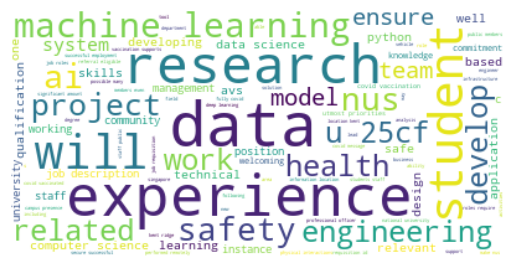

Cluster: 7
Titles:
College Intern - Data Science (Remote)
Junior Data Scientist
Data Science_AMTNP
Digital Performance Management_NPAMT
Digital Twin_NPAMT
Industrial Internet of Things_NPAMT
Paperless Solution_NPAMT
STEM @ OCBC Internship Programme 2021 - Analytics
Distribution & Logistics Data Analyst Intern
[Career Fest] Data Science Course Facilitator @ Proptech+B13:R13
Regional Commercial Operations Intern (May - Dec 2021)
Data Analyst Intern
IT Business Analyst Intern – Digital & Data Analytics
Business Analyst
Study on the Housing and Living Arrangements of Singles
Intern Data Analyst (Health and Nutrition)
Business Performance - Data Science Intern
Data Analyst
Intern - HR Analytics
HealthLine Suport for HPB Programme Jul to Dec 2021
Vacation Trainee, Analytics & Technology
Eat Drink Shop Healthy/Healthier Ingredient Devt Scheme-Jul
Analysis Intern
Product Management Intern
HR Analytics Intern
Data Operations Intern (Jul'21 - Dec'21)
Procurement Internship
Data Science Course Fa

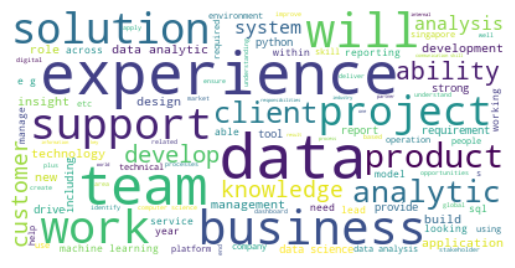

In [36]:
for k in range(0, num_clusters):
    s = clustered_data[clustered_data.cluster == k]
    text = s["description"].str.cat(sep=' ')
    text = text.lower()
    text = ' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    titles = clustered_data[clustered_data.cluster==k]['job title']
    
    print('Cluster: {}'.format(k))
    print('Titles:')
    print("\n".join(titles.unique()))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()